In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statannotations.Annotator import Annotator

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import scipy.stats
import statsmodels.stats.multitest as smm

# Load data

In [21]:
from analysis_utils import load_json_restore_arrays
data = load_json_restore_arrays('../data/data_electrophysiology.json')

In [22]:
# Calculate the mean spontaneous firing rate
data['firing_rate'] = data.spikes.apply(lambda x: len(x)) / data.recording_dur
data['firing_rate'] = data['firing_rate'].round(2).astype(float)

In [23]:
# Caclulate the spike half-width duration
from analysis_utils import get_waveshape_FWHM
data['waveshape_FWHM'] = data.apply(lambda row: get_waveshape_FWHM(row['waveshape'], row['waveshape_tv']), axis=1)

In [24]:
# Calculate the peak-to-trough duration
from analysis_utils import get_waveshape_peak_to_trough
data['waveshape_peakToTrough'] = data.apply(lambda row: get_waveshape_peak_to_trough(row['waveshape'], row['waveshape_tv']), axis=1)

# Statistics

In [25]:
features = ['firing_rate', 'waveshape_FWHM']  # Spontaneous ephys features

# Loop over the list of features
p_values = {}
for feature in features:
    x1 = data[data['TH_label'] == 'pos'][feature].dropna().to_numpy()
    x2 = data[data['TH_label'] == 'neg'][feature].dropna().to_numpy()

    stats, p = scipy.stats.mannwhitneyu(x=x1, y=x2)
    p = np.round(p, 3) 
    p_values[feature] = '{}'.format(p)  

# Print the results
for i, feature in enumerate(features):
    
    formatted_pval = p_values.get(feature)
    
    # Recalculate x1 and x2 to get counts
    x1 = data[data['TH_label'] == 'pos'][feature].dropna().to_numpy()
    x2 = data[data['TH_label'] == 'neg'][feature].dropna().to_numpy()
    
    # Calculate mean and standard deviation for pos and neg
    mean_x1 = np.round(np.mean(x1), 2)
    std_x1 = np.round(np.std(x1, ddof=1), 2)
    mean_x2 = np.round(np.mean(x2), 2)
    std_x2 = np.round(np.std(x2, ddof=1), 2)
    
    print(f'Feature: {feature}')
    print('N_pos =', len(x1))
    print('N_neg =', len(x2))
    print('Mean±std (pos): {} ± {}'.format(mean_x1, std_x1))
    print('Mean±std (neg): {} ± {}'.format(mean_x2, std_x2))
    print('Corrected p-value:', formatted_pval)
    print('---')

Feature: firing_rate
N_pos = 30
N_neg = 20
Mean±std (pos): 1.21 ± 0.78
Mean±std (neg): 0.77 ± 0.62
Corrected p-value: 0.036
---
Feature: waveshape_FWHM
N_pos = 30
N_neg = 20
Mean±std (pos): 0.83 ± 0.18
Mean±std (neg): 0.69 ± 0.14
Corrected p-value: 0.008
---


# Plotting

In [26]:
df_pos = data[data['TH_label'] == 'pos']
df_neg = data[data['TH_label'] == 'neg']

In [27]:
colors = ['#7570b3', '#1b9e77']
plt.rcParams['svg.fonttype'] = 'none'

### Figure 2A: Firing rate

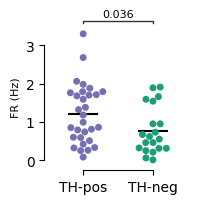

In [28]:
feature = 'firing_rate'
formatted_pvals_plot = [p_values.get(feature)]

fig, ax = plt.subplots(1,1,figsize=(1.8,1.8))

sns.swarmplot(data=data,
             x='TH_label',
             y=feature,
             palette=colors,
             ax=ax)
ax.plot([-.2, .2], [np.mean(df_pos[feature].values), np.mean(df_pos[feature].values)], color='k')
ax.plot([.8, 1.2], [np.mean(df_neg[feature].values), np.mean(df_neg[feature].values)], color='k')

ax.set_xlabel('')
ax.set_xticklabels(['TH-pos', 'TH-neg'], fontsize=8)
ax.set_ylabel('FR (Hz)', fontsize=8)

# Stats annotations
annotator = Annotator(data=data,
                      x='TH_label',
                      y=feature,
                      pairs=[('pos','neg')],
                      order=None, 
                      orient='v',
                      short_test_name=False,
                      ax=ax,
                      verbose=False
                      )
annotator.configure(loc='outside', fontsize=8, line_width=1)
annotator.set_custom_annotations(formatted_pvals_plot)
annotator.annotate()
    
sns.despine(offset=3,trim=True)

fig.patch.set_facecolor('white')

#fig.savefig('../plots/ephys_firing_rate.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig('../plots/ephys_firing_rate.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

plt.show()

### Figure 2C: Spike half-width

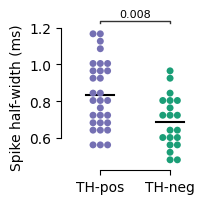

In [29]:
feature = 'waveshape_FWHM'
formatted_pvals_plot = [p_values.get(feature)]

fig, ax = plt.subplots(1,1,figsize=(1.8, 1.8))

sns.swarmplot(data=data,
             x='TH_label',
             y=feature,
             palette=colors,
             ax=ax)

ax.plot([-.2, .2], [np.mean(df_pos[feature].values), np.mean(df_pos[feature].values)], color='k')
ax.plot([.8, 1.2], [np.mean(df_neg[feature].values), np.mean(df_neg[feature].values)], color='k')

ax.set_xlabel('')
ax.set_xticklabels(['TH-pos', 'TH-neg'])
ax.set_ylabel('Spike half-width (ms)')

# Stats annotations
annotator = Annotator(data=data,
                      x='TH_label',
                      y=feature,
                      pairs=[('pos','neg')],
                      order=None, 
                      orient='v',
                      short_test_name=False,
                      ax=ax,
                      verbose=False
                      )
annotator.configure(loc='outside', fontsize=8, line_width=1)
annotator.set_custom_annotations(formatted_pvals_plot)
annotator.annotate()
    
sns.despine(offset=3,trim=True)

fig.savefig('../plots/ephys_spike_halfwidth.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
fig.savefig('../plots/ephys_spike_halfwidth.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

### Figure 2B: Mean Waveshapes

In [30]:
from analysis_utils import normalize_waveshape
data['waveshape_normalized'] = data['waveshape'].apply(normalize_waveshape)

In [31]:
feature = 'waveshape_normalized'
waveshape_tv = data['waveshape_tv'][0]

df_pos = data[data['TH_label'] == 'pos']
df_neg = data[data['TH_label'] == 'neg']

# Positive wave shape
waveshape_pos = np.vstack(df_pos[feature].values)
waveshape_pos_mean = np.mean(waveshape_pos, axis=0)
waveshape_pos_std = np.std(waveshape_pos, axis=0)
waveshape_pos_sem = waveshape_pos_std / np.sqrt(waveshape_pos.shape[0])

# Negative wave shape
waveshape_neg = np.vstack(df_neg[feature].values)
waveshape_neg_mean = np.mean(waveshape_neg, axis=0)
waveshape_neg_std = np.std(waveshape_neg, axis=0)
waveshape_neg_sem = waveshape_neg_std / np.sqrt(waveshape_neg.shape[0])

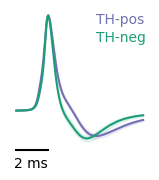

In [32]:
fig, ax = plt.subplots(1,1,figsize=(1.8, 1.8))

ax.plot(waveshape_tv, waveshape_pos_mean, color=colors[0])
ax.fill_between(waveshape_tv, waveshape_pos_mean-waveshape_pos_sem, y2=waveshape_pos_mean+waveshape_pos_sem, color=colors[0], alpha=.1)
ax.plot(waveshape_tv, waveshape_neg_mean, color=colors[1])
ax.fill_between(waveshape_tv, waveshape_neg_mean-waveshape_neg_sem, y2=waveshape_neg_mean+waveshape_neg_sem, color=colors[1], alpha=.1)

ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
sns.despine(bottom=True, right=True, left=True)

ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_bounds([0, 0.002])
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_position(('outward', 2))
ax.set_xlabel('2 ms', x=0.15)

fig.text(s='TH-pos', x=.6, y=.8, color=colors[0])
fig.text(s='TH-neg', x=.6, y=.7, color=colors[1])

fig.patch.set_facecolor('white')

#fig.savefig('../plots/ephys_waveshape.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig('../plots/ephys_waveshape.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

### Figure 2G, M: Group average ISI cumulative probability distributions

In [33]:
example_positive = 49 # Example positive cell
example_negative = 48 # Example negative cell

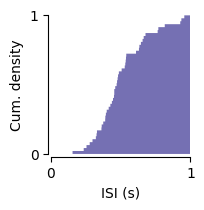

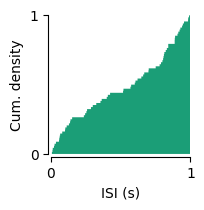

In [34]:

bins = np.arange(0, 1, 0.001)

# Plot for example positive cell
fig, ax = plt.subplots(figsize=(1.8, 1.8))
idx = data[data['Cell_Num'] == example_positive].index[0]
isi = np.diff(data['spikes'][idx])
ax.hist(isi, bins=bins, cumulative=True, density=True, histtype='stepfilled', color=colors[0])
ax.set(xlabel='ISI (s)', ylabel='Cum. density', xlim=[0, 1], ylim=[0, 1], xticks=[0, 1], yticks=[0, 1])
sns.despine(offset=2, trim=True)
plt.show()

fig.savefig('../plots/ephys_example_pos_cumsum_ISI.svg', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor())
fig.savefig('../plots/ephys_example_pos_cumsum_ISI.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor())

##########

# Plot for example negative cell
fig, ax = plt.subplots(figsize=(1.8, 1.8))
idx = data[data['Cell_Num'] == example_negative].index[0]
isi = np.diff(data['spikes'][idx])
ax.hist(isi, bins=bins, cumulative=True, density=True, histtype='stepfilled', color=colors[1])
ax.set(xlabel='ISI (s)', ylabel='Cum. density', xlim=[0, 1], ylim=[0, 1], xticks=[0, 1], yticks=[0, 1])
sns.despine(offset=2, trim=True)
plt.show()

#fig.savefig('../plots/ephys_example_neg_cumsum_ISI.svg', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor())
#fig.savefig('../plots/ephys_example_neg_cumsum_ISI.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor())

### Figure 2E: Group average ISI cumulative probability distributions

In [35]:
from analysis_utils import normalize_data

C:\Users\izouridis\AppData\Roaming\Python\Python311\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


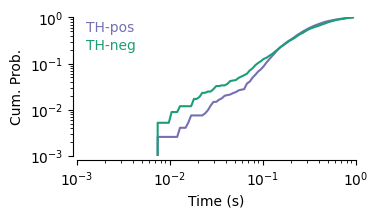

In [36]:
isi_min = 1e-3  # 1 ms
isi_max = 1
num_bins = 100  
bins = np.logspace(np.log10(isi_min), np.log10(isi_max), num=num_bins+1, base=10)
bin_centers = (bins[:-1] + bins[1:]) / 2  # Get the centers of the bins

ISIs = []
for i in range(data.shape[0]):
    spkt = data.at[i, 'spikes']
    isi = np.diff(spkt)
    isi_distr, isi_distr_bins = np.histogram(isi, bins=bins, density=True)
    if np.isnan(isi_distr).any():
        isi_distr = np.zeros(isi_distr.shape)
    else:
        isi_distr = normalize_data(isi_distr, range=[0,1])
    ISIs.append(isi_distr)
    
data['ISI_new'] = ISIs

feature = 'ISI_new'
df_pos = data[data['TH_label'] == 'pos']
df_neg = data[data['TH_label'] == 'neg']

ISI_tv = isi_distr_bins[:-1]

ISI_pos = np.vstack(df_pos[feature].values)
ISI_pos_cum = np.mean(np.cumsum(ISI_pos, axis=1), axis=0)
ISI_pos_cum /= ISI_pos_cum[-1]  # Normalize to make it between 0 and 1
ISI_pos_std = np.std(ISI_pos, axis=0)

ISI_neg = np.vstack(df_neg[feature].values)
ISI_neg_cum = np.mean(np.cumsum(ISI_neg, axis=1), axis=0)
ISI_neg_cum /= ISI_neg_cum[-1]  # Normalize to make it between 0 and 1
ISI_neg_std = np.std(ISI_neg, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(1.8 * 2, 1.8))

ax.plot(ISI_tv, ISI_pos_cum, color=colors[0])
ax.plot(ISI_tv, ISI_neg_cum, color=colors[1])

ax.set_ylabel('Cum. Prob.')
ax.set_xlabel('Time (s)')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim(0.001, 1)
ax.set_xlim(0.001, 1)

fig.text(s='TH-pos', x=.15, y=.8, color=colors[0])
fig.text(s='TH-neg', x=.15, y=.7, color=colors[1])

sns.despine(offset=3, trim=True)

#fig.savefig('../plots/ephys_ISI_log_cum.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig('../plots/ephys_ISI_log_cum.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

### Figure S4: All spike waveforms

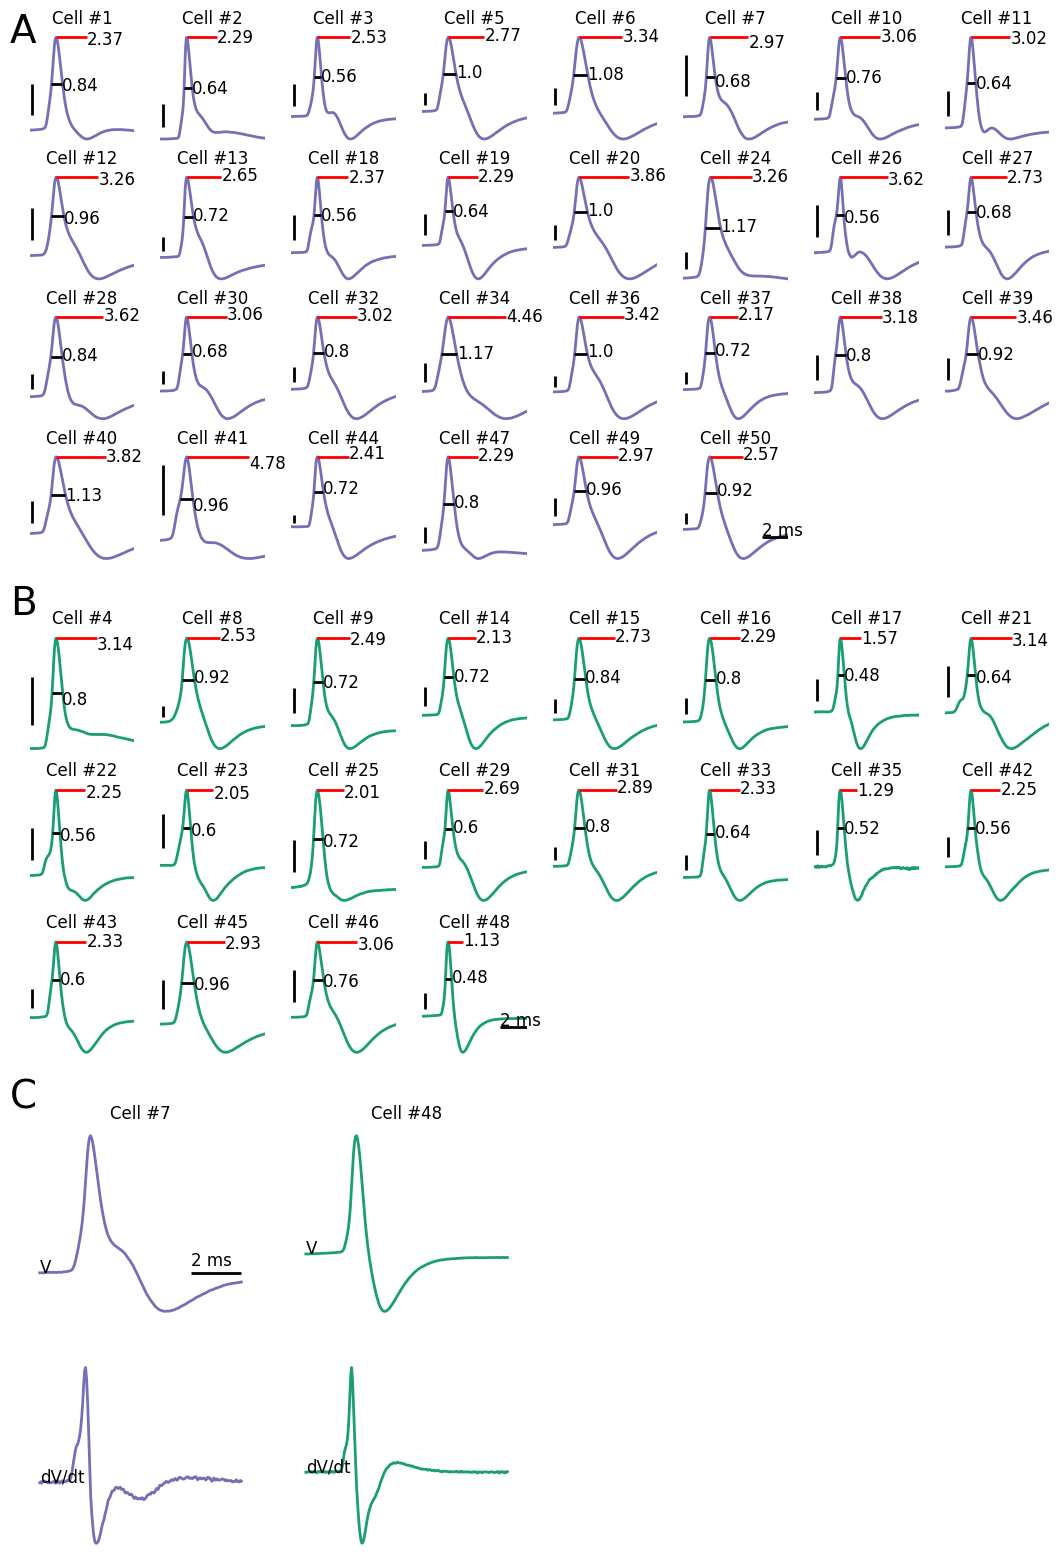

In [37]:
# Get the max amplitude of the waveshape
data['waveshape_max_amp'] = [np.max(wave) for wave in data['waveshape']]

# Separate data by TH label
data_pos = data[data['TH_label'] == 'pos'].sort_values(by='Cell_Num', ascending=True)
data_neg = data[data['TH_label'] == 'neg'].sort_values(by='Cell_Num', ascending=True)

# Separate data by TH values
th_pos_indices = data_pos.index
th_neg_indices = data_neg.index

# Create figure and main gridspec layout
fig = plt.figure(figsize=(15.48*0.85, 23.22*0.85))  # Adjusting the height

gs_main = gridspec.GridSpec(3, 1, height_ratios=[1.25, 1, 1], hspace=0.15)  # Set the height ratios here

# Create TH-positive subpanel and its subplots
th_pos_gs = gridspec.GridSpecFromSubplotSpec(4, 8, subplot_spec=gs_main[0], hspace=0.25, wspace=0.25)
for i, idx in enumerate(th_pos_indices):
    
    ax = plt.subplot(th_pos_gs[i])
    
    sns.lineplot(x=data_pos.waveshape_tv[idx]*1000, y=data_pos.waveshape[idx], ax=ax, color='#7570b3', linewidth=2)
    
    start_time_peak_to_trough = 2
    end_time_peak_to_trough = start_time_peak_to_trough + (data_pos.waveshape_peakToTrough[idx])
    y_val_peak_to_trough = data_pos.waveshape_max_amp[idx]
    ax.hlines(y=y_val_peak_to_trough, xmin=start_time_peak_to_trough, xmax=end_time_peak_to_trough, color='r', linestyle='-', linewidth=2)
    
    first_positive_crossing_index = np.where(np.diff(np.signbit(data_pos['waveshape'][idx] - (data_pos['waveshape_max_amp'][idx] / 2))))[0][0]
    start_time_fwhm = data_pos['waveshape_tv'][idx][first_positive_crossing_index] * 1000
    end_time_fwhm = start_time_fwhm + data_pos['waveshape_FWHM'][idx]
    y_val = data_pos['waveshape_max_amp'][idx] / 2
    ax.hlines(y=y_val, xmin=start_time_fwhm, xmax=end_time_fwhm, color='k', linestyle='-', linewidth=2)
    ax.set_title(' ')
    ax.set_axis_off()  
    ax.annotate(str(round(data_pos.waveshape_FWHM[idx], 2)), xy=(end_time_fwhm, data_pos.waveshape_max_amp[idx]/2), xytext=(end_time_fwhm+0.001, (data.waveshape_max_amp[idx]/2)-0.25), fontsize=12)
    ax.annotate(str(round(data_pos.waveshape_peakToTrough[idx], 2)), xy=(end_time_peak_to_trough, data_pos.waveshape_max_amp[idx]), xytext=(end_time_peak_to_trough+0.001, (data.waveshape_max_amp[idx])-0.25), fontsize=12)
    ax.set_xlim(data_pos.waveshape_tv[idx][0], data_pos.waveshape_tv[idx][-1]*1000)
    
    ax.vlines(x=0.2, ymin=0.5, ymax=1.5, color='k', linestyle='-', linewidth=2)
    
    ax.set_title(f'Cell #{data_pos.Cell_Num[idx]}', fontsize=12) 
    
    
    if i == 8:
         ax.set_ylabel('Amplitude (mV)')
    
    #scalebar
    if i == len(th_pos_indices)-1:
        ax.hlines(y=-0.7, xmin=6, xmax=8, color='k', linestyle='-', linewidth=2)
        ax.annotate('2 ms', xy=(6, -0.7), xytext=(6, -.6), fontsize=12)

# Create TH-negative subpanel
th_neg_gs = gridspec.GridSpecFromSubplotSpec(3, 8, subplot_spec=gs_main[1], hspace=0.25, wspace=0.25)
for i, idx in enumerate(th_neg_indices):
    ax = plt.subplot(th_neg_gs[i])
    
    sns.lineplot(x=data_neg.waveshape_tv[idx]*1000, y=data_neg.waveshape[idx], ax=ax, color='#1b9e77', linewidth=2)
    
    start_time_peak_to_trough = 2
    end_time_peak_to_trough = start_time_peak_to_trough + (data_neg.waveshape_peakToTrough[idx])
    y_val_peak_to_trough = data_neg.waveshape_max_amp[idx]
    ax.hlines(y=y_val_peak_to_trough, xmin=start_time_peak_to_trough, xmax=end_time_peak_to_trough, color='r', linestyle='-', linewidth=2)
    
    first_positive_crossing_index = np.where(np.diff(np.signbit(data_neg['waveshape'][idx] - (data_neg['waveshape_max_amp'][idx] / 2))))[0][0]
    start_time_fwhm = data_neg['waveshape_tv'][idx][first_positive_crossing_index] * 1000
    end_time_fwhm = start_time_fwhm + data_neg['waveshape_FWHM'][idx]
    y_val = data_neg['waveshape_max_amp'][idx] / 2
    ax.hlines(y=y_val, xmin=start_time_fwhm, xmax=end_time_fwhm, color='k', linestyle='-', linewidth=2)
    ax.set_title(' ')
    ax.set_axis_off()  
    ax.annotate(str(round(data_neg.waveshape_FWHM[idx], 2)), xy=(end_time_fwhm, data_neg.waveshape_max_amp[idx]/2), xytext=(end_time_fwhm+0.001, (data.waveshape_max_amp[idx]/2)-0.25), fontsize=12)
    ax.annotate(str(round(data_neg.waveshape_peakToTrough[idx], 2)), xy=(end_time_peak_to_trough, data_neg.waveshape_max_amp[idx]), xytext=(end_time_peak_to_trough+0.001, (data.waveshape_max_amp[idx])-0.25), fontsize=12)
    ax.set_xlim(data_neg.waveshape_tv[idx][0], data_neg.waveshape_tv[idx][-1]*1000)
    
    ax.vlines(x=0.2, ymin=0.5, ymax=1.5, color='k', linestyle='-', linewidth=2) #verical scalebar
    
    ax.set_title(f'Cell #{data_neg.Cell_Num[idx]}', fontsize=12)    
    ax.set_axis_off()
    
    if i == 8:
        ax.set_ylabel('Amplitude (mV)')
    
    #horizontal scalebar
    if i == len(th_neg_indices)-1:
        ax.hlines(y=-0.7, xmin=6, xmax=8, color='k', linestyle='-', linewidth=2)
        ax.annotate('2 ms', xy=(6, -0.7), xytext=(6, -.6), fontsize=12)
    
## Create third subpanel
third_gs = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs_main[2])

idx1 = data[data['Cell_Num'] == 7].index[0]
idx2 = data[data['Cell_Num'] == 48].index[0]

# First cell plot
ax = plt.subplot(third_gs[0, 0])
sns.lineplot(x=data.waveshape_tv[idx1], y=data.waveshape[idx1], color='#7570b3', linewidth=2, ax=ax)
ax.set_ylabel('Amplitude (mV)')
ax.annotate('V', xy=(0, 0), xytext=(0, 0), fontsize=12)
ax.set_axis_off()
ax.set_title(f'Cell #{data.Cell_Num[idx1]}', fontsize=12)

#add scalebar 2 ms
ax.hlines(y=0, xmin=0.006, xmax=0.008, color='k', linestyle='-', linewidth=2)
ax.annotate('2 ms', xy=(0.006, 0), xytext=(0.006, 0.1), fontsize=12)

# First cell derivative plot
ax = plt.subplot(third_gs[1, 0])
sns.lineplot(x=data.waveshape_tv[idx1][:-1], y=np.diff(data.waveshape[idx1]), color='#7570b3', linewidth=2, ax=ax)
ax.set_ylabel('Amplitude derivative (mV/ms)')

ax.annotate('dV/dt', xy=(0, 0), xytext=(0, 0), fontsize=12)
ax.set_axis_off()

# Second cell plot
ax = plt.subplot(third_gs[0, 1])
sns.lineplot(x=data.waveshape_tv[idx2], y=data.waveshape[idx2], color='#1b9e77', linewidth=2, ax=ax)
ax.annotate('V', xy=(0, 0), xytext=(0, 0), fontsize=12)
ax.set_axis_off()
ax.set_title(f'Cell #{data.Cell_Num[idx2]}', fontsize=12)

# Second cell derivative plot
ax = plt.subplot(third_gs[1, 1])
sns.lineplot(x=data.waveshape_tv[idx2][:-1], y=np.diff(data.waveshape[idx2]), color='#1b9e77', linewidth=2, ax=ax)
ax.annotate('dV/dt', xy=(0, 0), xytext=(0, 0), fontsize=12)
ax.set_axis_off()

fig.text(0.11, 0.89, "A", fontsize=28, verticalalignment='top', horizontalalignment='left')
fig.text(0.11, 0.6,  "B", fontsize=28, verticalalignment='top', horizontalalignment='left')
fig.text(0.11, 0.35, "C", fontsize=28, verticalalignment='top', horizontalalignment='left')

#plt.savefig('../plots/ephys_all_spike_waveforms.svg', dpi=300, bbox_inches='tight')
#plt.savefig('../plots/ephys_all_spike_waveforms.png', dpi=300, bbox_inches='tight')

plt.show()

# Some numbers

In [38]:
# Print some statements for the results section

idx = data[data['Cell_Num'] == example_positive].index[0]
print('Example positive cell: ', example_positive)
print('Spike rate:', data.loc[idx, 'firing_rate'])
print('FWHM:', data.loc[idx, 'waveshape_FWHM'].round(2))

print('---')

idx = data[data['Cell_Num'] == example_negative].index[0]
print('Example negative cell: ', example_negative)
print('Spike rate:', data.loc[idx, 'firing_rate'])
print('FWHM:', data.loc[idx, 'waveshape_FWHM'].round(2))

print('---')

print('Total number of neurons:', data.shape[0])
print('Number of TH-pos neurons:', data[data['TH_label'] == 'pos'].shape[0])
print('Number of TH-neg neurons:', data[data['TH_label'] == 'neg'].shape[0])

print('---')

print('Mean recording duration:', np.round(np.mean(data['recording_dur']), 2))
print('Std recording duration:', np.round(np.std(data['recording_dur'], ddof=0), 2))

print('---')

Example positive cell:  49
Spike rate: 0.51
FWHM: 0.96
---
Example negative cell:  48
Spike rate: 0.73
FWHM: 0.48
---
Total number of neurons: 50
Number of TH-pos neurons: 30
Number of TH-neg neurons: 20
---
Mean recording duration: 289.8
Std recording duration: 83.37
---
